# **Item (1)**

## Importação das bibliotecas que serão usadas ao longo do projeto

In [ ]:
# Importar bibliotecas
from google.colab import drive
from google.colab import files
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
import random
from scipy.io import loadmat

# Definindo o caminho raiz do Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Montando o drive e definindo o caminho principal para a pasta em que está a base de dados. Além disso, carregou-se a base de dados numa variável `mat`.

In [ ]:
# Definindo o caminho padrão para a pasta contendo os arquivos
# Caso dê erro neste ponto, por gentileza, me informar, para que
# eu possa compartilhar corretamente a pasta.

BASE_DIR = '/content/drive/MyDrive/ITA - Pessoal/8º Semestre/ET-287/Projetos/Projeto 2'
os.chdir(BASE_DIR)
os.listdir(BASE_DIR)

# Carregar o arquivo do dataset
mat = loadmat('S10.mat')

## Transformando a variável `mat` num `np.array` para melhor manipulá-la.

In [ ]:
# Obtendo a parte dos dados importante para o estudo
data = mat['data']
arr_data = np.array(data)
print(arr_data.shape)

(64, 1500, 40, 6)


# **Item (2)**

## Filtrando a base de dados pelo canal 61, utilizando as amostras de 125 a 1375 (totalizando 1250 amostras) e separando as frequências inteiras em classes de 0 a 7.

In [ ]:
# Variáveis que serão usadas lagumas vezes ao longo do código
fs = 250 # Frequência de amostragem
time_sample = slice(125, 1375) # Fixando o intervalo de amostras: 125 a 1375
channel_idx = 60  # Canal 61 (Oz), 0-based

# Selecionando o eletrodo 61
channel_61 = arr_data[channel_idx]

# Filtrando a janela de tempo
channel_61_filtered = channel_61[time_sample]

"""
Como se pede para pegar apenas frequências inteiras, sendo o passo de 0.2Hz, temos:

índice 0: freq. 8Hz    ---> 'classe' 0
índice 5: freq. 9Hz    ---> 'classe' 1
índice 10: freq. 10Hz  ---> 'classe' 2
índice 15: freq. 11Hz  ---> 'classe' 3
índice 20: freq. 12Hz  ---> 'classe' 4
índice 25: freq. 13Hz  ---> 'classe' 5
índice 30: freq. 14Hz  ---> 'classe' 6
índice 35: freq. 15Hz  ---> 'classe' 7

"""

# Convertendo os índices das frequências inteiras para o índice simplificado do roteiro
# índice simplificado → índice real no dataset
idx_map = {
    0: 0,    # 8 Hz
    1: 5,    # 9 Hz
    2: 10,   # 10 Hz
    3: 15,   # 11 Hz
    4: 20,   # 12 Hz
    5: 25,   # 13 Hz
    6: 30,   # 14 Hz
    7: 35    # 15 Hz
}

# Filtrando as faixas de interesse. Utilizaremos as faixas de 9Hz e 15Hz
k1, k2 = idx_map[1], idx_map[7]
f9hz_channel_61 = channel_61_filtered[:,k1,:] # CLASSE +1
f15hz_channel_61 = channel_61_filtered[:,k2,:] # CLASSE -1

f_mixed = np.concatenate([f9hz_channel_61, f15hz_channel_61], axis=1) # (1250, 12)

X = f_mixed.T # (12, 1250)

y = np.array([1, 1, 1, 1, 1, 1,-1,-1,-1,-1,-1,-1]).reshape(12,1)
y = y.ravel() # (12,)

#Verificação
print("X shape:", X.shape)   # (12, 1250)
print("y shape:", y.shape)   # (12,)
print("y:", y)               # [ 1 1 1 1 1 1 -1 -1 -1 -1 -1 -1]

X shape: (12, 1250)
y shape: (12,)
y: [ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]


## Separação dos grupos de treino e validação (4 p/ treino, 2 p/ validação)

Para selecionar amostras aleatórias, os índices de `y`foram fatiados de 0 a 6 e de 6 a 12. Após isso, esses índices foram embaralhados e os valores de treino e validação foram selecionados com base nessa nova ordem aleatória, para ambas as frequências (9Hz e 15Hz).

Finalmente, após concatenar as fatias de treino (9Hz e 15Hz) e de validação (9Hz e 15Hz), esse novo array foi novamente embaralhado, para não priorizar a ordem 9Hz -->  15Hz.

In [ ]:
# índices por classe na ordem atual
idx_pos = np.arange(0,6) # Índices de 0 a 5 p/ amostras de 9hz, classe +1
idx_neg = np.arange(6,12) # Índices de 6 a 11 p/ amostras de 15hz, classe -1
print(idx_pos)
print(idx_neg, '\n')

# Embaralhando as amostras para selecionar aleatoriamente
np.random.shuffle(idx_pos)
np.random.shuffle(idx_neg)
print("Nova ordem de índices: ", idx_pos)
print("Nova ordem de índices: ", idx_neg, '\n')

# Separando os grupos de treino (4) e validação (2)
# Pegando as 4 primeiras amostras de cada grupo embaralhado
train_9hz, val_9hz = idx_pos[:4], idx_pos[4:]
train_15hz, val_15hz = idx_neg[:4], idx_neg[4:]

train = np.concatenate([train_9hz, train_15hz]) # 8 amostras
val = np.concatenate([val_9hz, val_15hz]) # 4 amostras
print("Índices de treino concatenados: ", train)
print("Índices de validação concatenados: ", val, '\n')

# Embaralhando os índices para não favorecer a ordem (9Hz -> 15Hz)
np.random.shuffle(train)
np.random.shuffle(val)
print("Nova ordem de índices de treino, 9Hz e 15Hz misturados: ", train)
print("Nova ordem de índices de validação, 9Hz e 15Hz misturados: ", val)

# Organização dos vetores já normalizado de acordo com os índices finais, em ordem aleatória
X_train, y_train = X[train], y[train]
X_val, y_val = X[val], y[val]


[0 1 2 3 4 5]
[ 6  7  8  9 10 11] 

Nova ordem de índices:  [0 2 3 4 5 1]
Nova ordem de índices:  [ 8  6 11 10  9  7] 

Índices de treino concatenados:  [ 0  2  3  4  8  6 11 10]
Índices de validação concatenados:  [5 1 9 7] 

Nova ordem de índices de treino, 9Hz e 15Hz misturados:  [ 4  6  8  0 10  2 11  3]
Nova ordem de índices de validação, 9Hz e 15Hz misturados:  [7 1 9 5]


# **Item (3)**

## Funções auxiliares para treinamento do perceptron,  predição e  avaliação.

In [ ]:

# Definição de hiperparâmetros
learning_rate = 0.01  # Taxa de aprendizado
max_epochs = 1000     # Número de épocas
growth = 1.01         # Taxa de crescimento
add_epochs = 20       # Parcela a ser somada a max_epochs


# Função de ativação do perceptron: signal(x)
def activation_func(xi, w, b):
    sum = np.dot(xi, w) + b
    return 1 if sum >= 0 else -1


# Função para treinamento do perceptron
def train_perceptron(X, y, learning_rate, num_epochs):

    #Inicialização dos pesos com valores aleatórios
    w = np.random.rand(X.shape[1])
    b = np.random.rand()

    # Treinamento do perceptron
    for epoch in range(num_epochs):
        for xi, target in zip(X, y):
            prediction = activation_func(xi, w, b)
            error = target - prediction
            w += learning_rate * error * xi
            b += learning_rate * error

    return w, b


def evaluate(X, y_targets, w, b):
    n_correct = 0
    for xi, target in zip(X, y_targets):
        prediction = activation_func(xi, w, b)
        if prediction == target:
            n_correct += 1
    accuracy = (n_correct / len(y_targets))

    return accuracy

## Definição dos hiperparâmetros e treinamento do perceptron. Aqui serão armazenados no dicionário os dados que geram cada acurácia.

In [ ]:
# Dicionário para armazenar valores que geram a acurácia relativa a cada chave
accuracy_results = {0.50: None, 0.75: None, 1.00: None,}

# Dicionário para estatísticas de quantas vezes cada acurácia foi obtida
accuracy_stats = {0.0: 0, 0.25: 0, 0.50: 0, 0.75: 0, 1.00: 0}

# Para cada acurácia do conjunto, faça:
for target_accuracy in sorted(accuracy_results.keys()):

    print("Buscando um modelo com acurácia de ", target_accuracy*100,"%...")

    done = False
    current_lr = 0.001
    current_epochs = 1000
    lr_growth = 1.01
    epoch_increment = 10

    attempts = 0

    while not done:
        attempts += 1

        # Inicialização dos pesos e bias
        w = np.random.rand(X_train.shape[1])
        b = np.random.rand()

        # Treinamento do perceptron
        w_trained, b_trained = train_perceptron(X_train, y_train, current_lr, current_epochs)

        # Avaliação do modelo
        obtained_accuracy = evaluate(X_val, y_val, w_trained, b_trained)

        print(f"Alvo: {target_accuracy*100:.0f}% | Acurácia Obtida: {obtained_accuracy*100:.0f}% (LR: {current_lr:.5f}, Épocas: {current_epochs})")

        # Atualiza as estatísticas
        if obtained_accuracy in accuracy_stats:
            accuracy_stats[obtained_accuracy] += 1

        # Verifica se alcançou a acurácia desejada para evoluir
        if obtained_accuracy == target_accuracy:
            print(f"Modelo para {target_accuracy*100:.0f}% encontrado.")
            accuracy_results[target_accuracy] = {
                "weights": w_trained.copy(),
                "bias": b_trained,
                "learning_rate": current_lr,
                "epochs": current_epochs,
                "attempts": attempts
            }
            done = True
        else:
            # Se não atingiu, ajusta os hiperparâmetros para a próxima tentativa
            current_lr *= lr_growth
            current_epochs += epoch_increment


print(accuracy_results)

# Estatísticas finais de acurácia
for accuracy, count in accuracy_stats.items():
    print(f"Acurácia {accuracy*100:.0f}% encontrada {count} vezes.")

Buscando um modelo com acurácia de  50.0 %...
Alvo: 50% | Acurácia Obtida: 75% (LR: 0.00100, Épocas: 1000)
Alvo: 50% | Acurácia Obtida: 50% (LR: 0.00101, Épocas: 1010)
Modelo para 50% encontrado.
Buscando um modelo com acurácia de  75.0 %...
Alvo: 75% | Acurácia Obtida: 50% (LR: 0.00100, Épocas: 1000)
Alvo: 75% | Acurácia Obtida: 75% (LR: 0.00101, Épocas: 1010)
Modelo para 75% encontrado.
Buscando um modelo com acurácia de  100.0 %...
Alvo: 100% | Acurácia Obtida: 50% (LR: 0.00100, Épocas: 1000)
Alvo: 100% | Acurácia Obtida: 50% (LR: 0.00101, Épocas: 1010)
Alvo: 100% | Acurácia Obtida: 75% (LR: 0.00102, Épocas: 1020)
Alvo: 100% | Acurácia Obtida: 75% (LR: 0.00103, Épocas: 1030)
Alvo: 100% | Acurácia Obtida: 50% (LR: 0.00104, Épocas: 1040)
Alvo: 100% | Acurácia Obtida: 75% (LR: 0.00105, Épocas: 1050)
Alvo: 100% | Acurácia Obtida: 50% (LR: 0.00106, Épocas: 1060)
Alvo: 100% | Acurácia Obtida: 50% (LR: 0.00107, Épocas: 1070)
Alvo: 100% | Acurácia Obtida: 75% (LR: 0.00108, Épocas: 1080)
Alv

## Verificando os conjuntos de pesos e bias encontrados com o conjunto de validação, para certificar-se de que a acurácia prevista é realmente obtida

In [ ]:
print(accuracy_results, '\n\n')

for acc_key, model_data in accuracy_results.items():
    print (f"Modelo de {acc_key * 100:.0f}% de Acurácia")

    # Recupera os dados do modelo salvo
    w_saved = model_data["weights"]
    b_saved = model_data["bias"]

    # Roda as predições com os pesos treinados do modelo
    y_predict = []
    for xi in X_val:
        prediction = activation_func(xi, w_saved, b_saved)
        y_predict.append(prediction)

    # Mostra os resultados na tela
    y_predict = np.array(y_predict)

    # Recalcula a acurácia
    correct_predictions = np.sum(y_val == y_predict)
    total_samples = len(y_val)
    verified_accuracy = correct_predictions / total_samples

    print(f"   - Targets (y_val):  {y_val}")
    print(f"   - Preditos (y_pred): {y_predict}")
    print(f"   - Acurácia Verificada: {verified_accuracy*100:.0f}%")

    if verified_accuracy == acc_key:
        print("A acurácia corresponde à esperada.")
    else:
        print("A acurácia não corresponde à esperada.")





{0.5: {'weights': array([0.6102151 , 1.02694143, 0.25317971, ..., 0.32580952, 0.07600987,
       0.27080065]), 'bias': np.float64(0.3421170738589825), 'learning_rate': 0.00101, 'epochs': 1010, 'attempts': 2}, 0.75: {'weights': array([0.55689481, 0.31045887, 0.10367588, ..., 0.06565984, 0.39357577,
       0.92932021]), 'bias': np.float64(0.6591962199501537), 'learning_rate': 0.00101, 'epochs': 1010, 'attempts': 2}, 1.0: {'weights': array([ 0.68015336,  0.66086965, -0.06395323, ...,  0.83679566,
        0.64498148,  0.29972363]), 'bias': np.float64(0.4370878371019774), 'learning_rate': 0.016876024774621478, 'epochs': 3840, 'attempts': 285}} 


Modelo de 50% de Acurácia
   - Targets (y_val):  [-1  1 -1  1]
   - Preditos (y_pred): [-1 -1  1  1]
   - Acurácia Verificada: 50%
A acurácia corresponde à esperada.
Modelo de 75% de Acurácia
   - Targets (y_val):  [-1  1 -1  1]
   - Preditos (y_pred): [-1 -1 -1  1]
   - Acurácia Verificada: 75%
A acurácia corresponde à esperada.
Modelo de 100% de 

# **Item (4)**

## Como visto acima, os pesos, bem como a taxa de aprendizado e o número de épocas de treinamento influenciam bastante na obtenção da acurácia desejada.

## Pode-se perceber que, para uma acurácia de 100%, os pesos possuem bastante variação entre si, girando em torno de 0.6 a 0.8.

# **Item (5)**

No domínio do tempo (1250 amostras), as repetições de dos dados têm deslocamentos de fase e variações de amplitude, o que dificulta um hiperplano fixo separar todos os ensaios de 9 Hz e 15 Hz. Logo, apenas um perceptron pode não obter o resultado perfeito e, na prática, pode não haver separabilidade perfeita.

Já no domínio da frequência, ao projetar features focadas nos fundamentais e harmônicos, o problema se aproxima de uma fronteira linear, com espectros melhor definidos. Com essas features, o perceptron costuma alcançar acurácia alta (frequentemente 100% neste conjunto pequeno).

# **Item (6)**

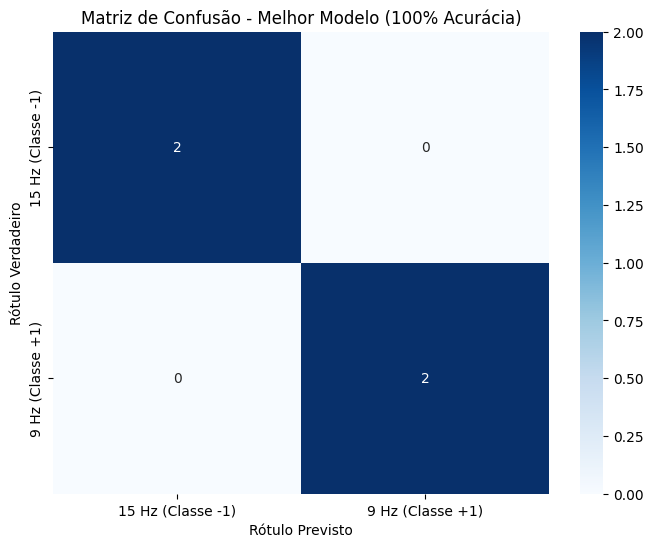

In [ ]:
# Importar as bibliotecas necessárias para a matriz de confusão
from sklearn.metrics import confusion_matrix
import seaborn as sns

best_model_key = 1.0
best_model_data = accuracy_results.get(best_model_key)

w = best_model_data["weights"]
b = best_model_data["bias"]
y_pred = []
for xi in X_val:
    prediction = activation_func(xi, w, b)
    y_pred.append(prediction)
y_pred = np.array(y_pred)

confusion_matrix = confusion_matrix(y_val, y_pred)

# Define os nomes dos eixos para o gráfico
axis_labels = ['15 Hz (Classe -1)', '9 Hz (Classe +1)']

# Cria a visualização da matriz
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=axis_labels, yticklabels=axis_labels)

# Adiciona títulos e labels para clareza
plt.title('Matriz de Confusão - Melhor Modelo (100% Acurácia)')
plt.ylabel('Rótulo Verdadeiro')
plt.xlabel('Rótulo Previsto')

# Exibe o gráfico
plt.show()



# **Item (7)**

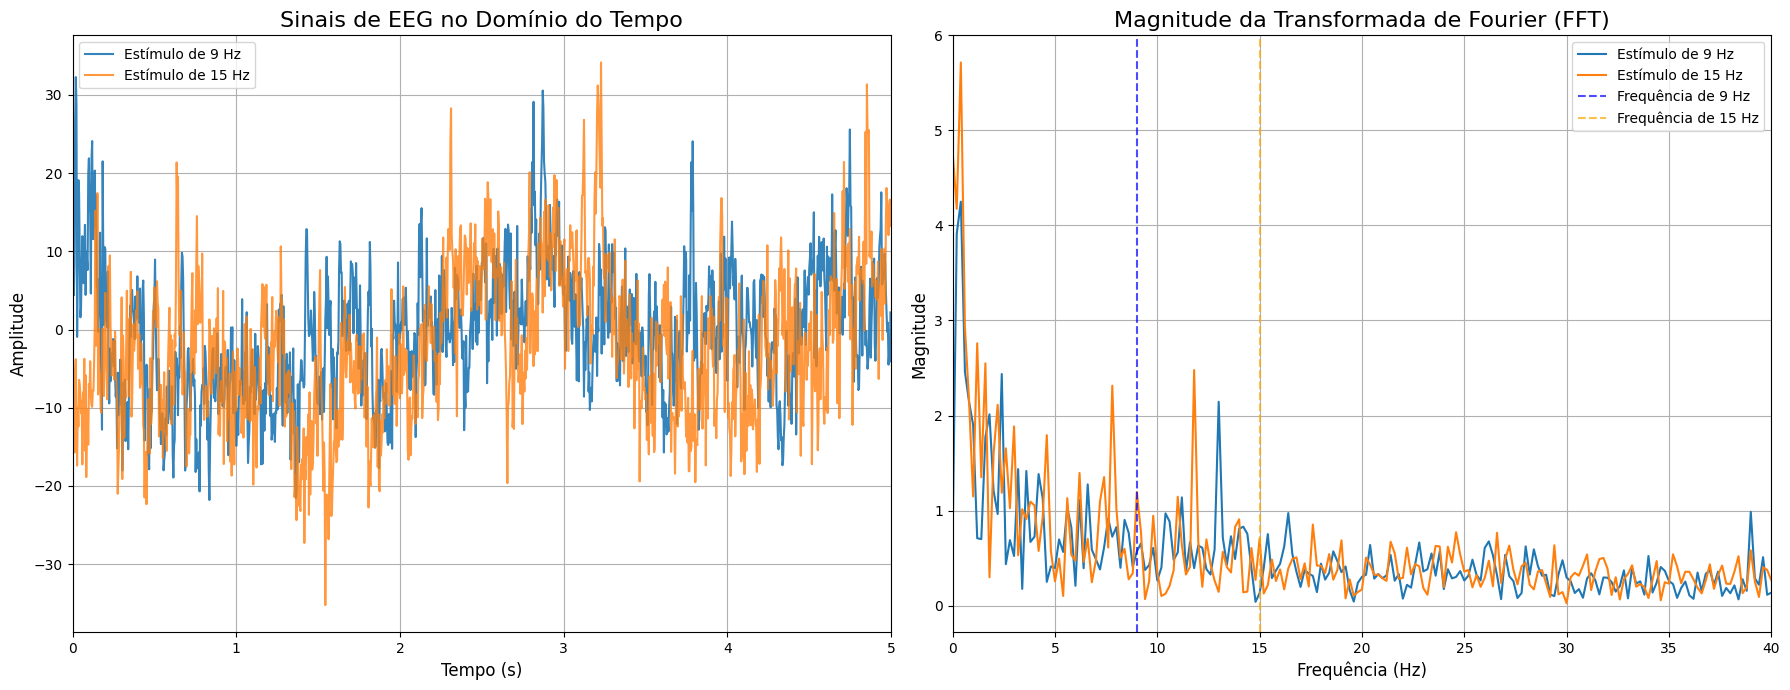

In [ ]:
from scipy.fft import fft, fftfreq

# Seleciona a primeira amostra de cada classe de frequência
sample_f9hz_channel_61 = f9hz_channel_61[:, 0]
sample_f15hz_channel_61 = f15hz_channel_61[:, 0]

# Parâmetros do sinal
N = 1250     # Número de pontos de amostragem
fs = 250     # Frequência de amostragem
T = 1.0 / fs # Período de amostragem

# Domínio do tempo
time_axis = np.linspace(0.0, N*T, N, endpoint=False)

# Domínio da frequência
yf_9hz = fft(sample_f9hz_channel_61)
yf_15hz = fft(sample_f15hz_channel_61)
xf = fftfreq(N, T)[:N//2]

# Magnitude normalizada da FFT no lado positivo do espectro
magnitude_9hz = 2.0/N * np.abs(yf_9hz[0:N//2])
magnitude_15hz = 2.0/N * np.abs(yf_15hz[0:N//2])

# Plotando os gráficos
plt.figure(figsize=(18, 7))

# Gráfico 1: Domínio do Tempo
plt.subplot(1, 2, 1)
plt.plot(time_axis, sample_f9hz_channel_61, label='Estímulo de 9 Hz', alpha=0.9)
plt.plot(time_axis, sample_f15hz_channel_61, label='Estímulo de 15 Hz', alpha=0.8)
plt.title('Sinais de EEG no Domínio do Tempo', fontsize=16)
plt.xlabel('Tempo (s)', fontsize=12)
plt.ylabel('Amplitude', fontsize=12)
plt.legend()
plt.grid(True)
plt.xlim(0, 5) # Limita o eixo do tempo para 5 segundos de dados

# Gráfico 2: Domínio da Frequência
plt.subplot(1, 2, 2)
plt.plot(xf, magnitude_9hz, label='Estímulo de 9 Hz')
plt.plot(xf, magnitude_15hz, label='Estímulo de 15 Hz')

# Adiciona linhas verticais para destacar as frequências de interesse
plt.axvline(x=9, color='blue', linestyle='--', alpha=0.7, label='Frequência de 9 Hz')
plt.axvline(x=15, color='orange', linestyle='--', alpha=0.7, label='Frequência de 15 Hz')

plt.title('Magnitude da Transformada de Fourier (FFT)', fontsize=16)
plt.xlabel('Frequência (Hz)', fontsize=12)
plt.ylabel('Magnitude', fontsize=12)
plt.legend()
plt.grid(True)
plt.xlim(0, 40) # Limita o eixo da frequência para focar nos picos de interesse

plt.tight_layout()
plt.show()

Pode-se obervar que o domínio da frequência é bem menos "ruidoso", no sentido de que é possível perceber com melhor clareza os picos das frequências de 9Hz e das de 15Hz, principalmente para baixas frequências. Dessa forma, pode ser possível treinar o perceptron com um conjunto menor de dados, alterando-se o formato das amostras (domínio da frequência ao invés de domínio do tempo).

# **Item (8)**

## Extração de potência espectral nas frequências de interesse

--- Transformação de Domínio ---
Shape da Matriz Original (Tempo):    (12, 1250)
Shape da Nova Matriz (Frequência): (12, 2)

--- Novos Dados de Treino (8 amostras, 2 características) ---
[[286.2740745  190.90845735]
 [747.06276793 440.74360361]
 [809.12246084 157.32434914]
 [355.83314773  82.46834374]
 [510.74282625 221.88094494]
 [108.38513552  28.74856893]
 [389.06609398 396.74685518]
 [731.50718671 701.12044254]]

--- Treinando o Perceptron com os Dados de Frequência ---

Acurácia final no conjunto de validação: 50%
O modelo convergiu em 50 épocas.


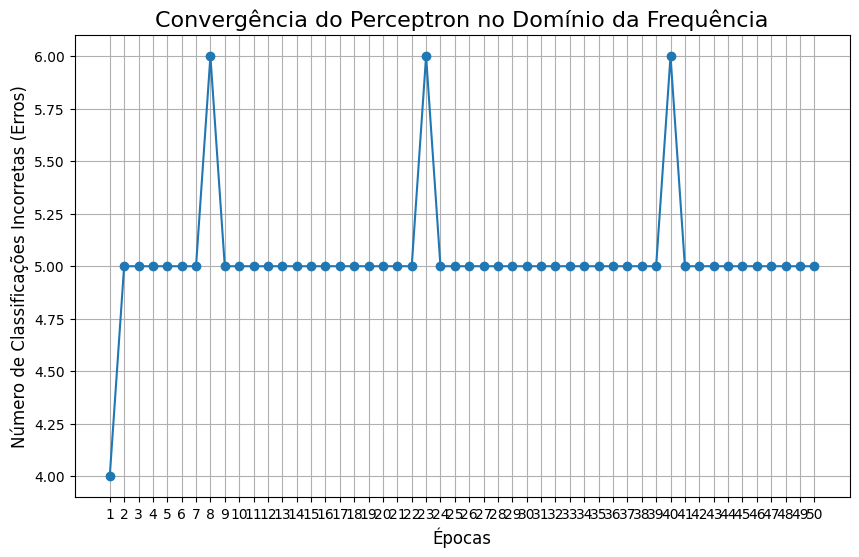

In [ ]:
# Importa as bibliotecas da FFT
from scipy.fft import rfft, rfftfreq

#Extrair características da FFT

def extract_fft_features(X_raw, target_freqs, fs):

    n_trials, n_samples = X_raw.shape

    # Gera o eixo de frequência para FFT de sinais reais (rfft)
    freq_axis = rfftfreq(n_samples, 1 / fs)

    all_features = []

    # Itera sobre cada sinal (cada linha de X)
    for trial_signal in X_raw:
        # Usa rfft (FFT para sinais reais), que é mais eficiente
        yf = rfft(trial_signal)
        magnitude_spectrum = np.abs(yf)

        current_trial_features = []
        # Para cada frequência alvo, encontra a magnitude no ponto mais próximo
        for freq in target_freqs:
            # Encontra o índice no eixo de frequência mais próximo da frequência alvo
            closest_freq_idx = np.argmin(np.abs(freq_axis - freq))

            # Pega a magnitude naquele ponto
            magnitude_at_freq = magnitude_spectrum[closest_freq_idx]
            current_trial_features.append(magnitude_at_freq)

        all_features.append(current_trial_features)

    return np.array(all_features)

# Frequências que usaremos como nossas novas características
target_frequencies = [9, 15]

# Extrai as 2 características para cada uma das 12 amostras
# A matriz X original tem shape (12, 1250)
X_fft = extract_fft_features(X, target_freqs=target_frequencies, fs=fs)

print("--- Transformação de Domínio ---")
print(f"Shape da Matriz Original (Tempo):    {X.shape}")
print(f"Shape da Nova Matriz (Frequência): {X_fft.shape}\n")

# Divide a NOVA matriz de características usando os MESMOS índices de antes
# Isso garante que a comparação seja justa
X_train_fft, y_train_fft = X_fft[train], y[train]
X_val_fft, y_val_fft = X_fft[val], y[val]

print("--- Novos Dados de Treino (8 amostras, 2 características) ---")
print(X_train_fft)


# Analisando a convergência

def train_perceptron_v2(X, y, learning_rate, n_epochs):
    rgen = np.random.RandomState(1) # Seed
    w = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
    b = np.float64(0.)
    errors_per_epoch = []

    for _ in range(n_epochs):
        errors = 0
        for xi, target in zip(X, y):
            prediction = 1 if (np.dot(xi, w) + b) >= 0.0 else -1
            if prediction != target:
                update = learning_rate * target
                w += update * xi
                b += update
                errors += 1
        errors_per_epoch.append(errors)
        if errors == 0: # Para se convergiu
            break

    return w, b, errors_per_epoch

# Hiperparâmetros para o novo treinamento
lr_fft = 0.01
epochs_fft = 50 # Provavelmente não precisaremos de tantas

print("\n--- Treinando o Perceptron com os Dados de Frequência ---")

# Treina o Perceptron
w_fft, b_fft, errors_history_fft = train_perceptron_v2(X_train_fft, y_train_fft, lr_fft, epochs_fft)

# Avalia o resultado final
final_accuracy = evaluate(X_val_fft, y_val_fft, w_fft, b_fft)
print(f"\nAcurácia final no conjunto de validação: {final_accuracy*100:.0f}%")


# Visualização da convergência

epochs_to_converge = len(errors_history_fft)
print(f"O modelo convergiu em {epochs_to_converge} épocas.")

plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs_to_converge + 1), errors_history_fft, marker='o', linestyle='-')
plt.title('Convergência do Perceptron no Domínio da Frequência', fontsize=16)
plt.xlabel('Épocas', fontsize=12)
plt.ylabel('Número de Classificações Incorretas (Erros)', fontsize=12)
plt.xticks(range(1, epochs_to_converge + 1))
plt.grid(True)
plt.show()

Como se pode verificar, utilizando o domínio da frequência, o perceptron converge muito mais rápido para uma solução que satisfaz o critério de 100% de acurácia.